# SD201 : Mining of large datasets

## Music genre classification using song lyrics

Before using our notebook, make sure you are running a Python environment that includes the following packages : 

* Nltk
* Scikit-learn
* Wordcloud
* langdetect
* the usuals : Pandas, Numpy, Matplotlib

Try to run the next cell to see if you have any missing package

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

from langdetect import detect

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics

## Using our own dataset

### 1. Cleaning of the dataset

#### 1.1 Raw data exploration

The dataset is a .csv file we obtained by scrapping lyrics through the [Genius](https://genius.com/) website using their API. The scrapping code is available on the repository

In [2]:
# Loading our dataset from the .csv file
data = pd.read_csv("datasets/genius-scrap.csv", sep='#')

In [3]:
# Inspecting the columns and the content
print("Size : "+str(data.shape))
print("Types :")
print(data.dtypes)
data.head()


Size : (6858, 5)
Types :
artist    object
title     object
lyrics    object
genre     object
url       object
dtype: object


,artist,title,lyrics,genre,url
0,Eminem,Rap God,"Rap God Lyrics\n""Look, I was gonna go easy on ...",rap,https://genius.com/Eminem-rap-god-lyrics
1,Cardi B,WAP,WAP Lyrics\nWhores in this house\nThere's some...,rap,https://genius.com/Cardi-b-wap-lyrics
2,Kendrick Lamar,HUMBLE.,HUMBLE. Lyrics\nNobody pray for me\nIt been th...,rap,https://genius.com/Kendrick-lamar-humble-lyrics
3,Migos,Bad and Boujee,"Bad and Boujee Lyrics\nYou know, young rich ni...",rap,https://genius.com/Migos-bad-and-boujee-lyrics
4,Drake,God's Plan,God’s Plan Lyrics\nAnd they wishin' and wishin...,rap,https://genius.com/Drake-gods-plan-lyrics


#### 1.2 Raw data cleaning

In [4]:
# Removing unwanted columns
data = data.drop(columns = ['artist','title','url'])

In [5]:
# Is there any missing values ?
data.isna().sum()[data.isna().sum() > 0]

lyrics    25
dtype: int64

In [6]:
# Handeling missing values by deleting rows where the lyrics are missing
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
# Check if dropping went right
data.isna().sum()

lyrics    0
genre     0
dtype: int64

In [8]:
# Deleting the "[title]-Lyrics" from the beginning of each lyrics and "[number xxx]Embed" from the end 
# Deleting the non-english lyrics as well

for i in range(len(data['lyrics'])):
    if(detect(data['lyrics'][i]) != 'en'):
        data.drop([i])

    if(re.findall(r'\d+.*Embed.*', data['lyrics'][i])!=[]):
        data['lyrics'][i] = data['lyrics'][i].split(re.findall(r'\d+.*Embed.*', data['lyrics'][i])[0])[0]

    if (re.findall(r'\bLyrics\b', data['lyrics'][i])!=[]):
        data['lyrics'][i] = data['lyrics'][i].split('Lyrics')[1]
    data['lyrics'][i] = data['lyrics'][i].lower()

In [10]:
# Checking the data cleaning on a random song lyrics
print(data['lyrics'][0])


"look, i was gonna go easy on you not to hurt your feelings"
"but i'm only going to get this one chance" (six minutes—, six minutes—)
"something's wrong, i can feel it" (six minutes, slim shady, you're on!)
"just a feeling i've got, like something's about to happen, but i don't know what. 
if that means what i think it means, we're in trouble, big trouble; 
and if he is as bananas as you say, i'm not taking any chances"
"you are just what the doc ordered"

i'm beginnin' to feel like a rap god, rap god
all my people from the front to the back nod, back nod
now, who thinks their arms are long enough to slap box, slap box?
they said i rap like a robot, so call me rap-bot
but for me to rap like a computer it must be in my genes
i got a laptop in my back pocket
my pen'll go off when i half-cock it
got a fat knot from that rap profit
made a livin' and a killin' off it
ever since bill clinton was still in office
with monica lewinsky feelin' on his nutsack
i'm an mc still as honest
but as rud

In [11]:
# Common repeated words by genre
for the_genre in data.genre.unique():
    print(the_genre)
    print(data.loc[data['genre'] == the_genre].lyrics.str.split(expand=True).stack().value_counts()[0:10])

rap
i      22876
the    21078
you    17272
a      13159
and    10561
my     10372
to     10145
in      7595
i'm     7587
me      7367
dtype: int64
hip-hop
the    24322
i      22628
you    17415
a      14681
to     13017
and    12831
my     10654
in      8422
i'm     8143
me      7899
dtype: int64
country
i      1600
you    1409
the    1300
and    1042
a       810
to      712
me      536
it      517
in      494
my      493
dtype: int64
rock
the    10840
i      10444
you    10203
and     6647
to      5817
a       5419
my      4284
me      4026
in      3858
it      3291
dtype: int64
pop
i      11874
you    11518
the     9052
to      5307
and     5302
a       5088
my      4705
me      4471
it      3975
i'm     3579
dtype: int64
r-b
you    19336
i      18199
the    12787
to      8145
me      7346
a       7212
and     7139
my      6979
it      6151
i'm     5389
dtype: int64
metal
the    12449
you     8058
i       7319
to      5531
and     5063
a       4784
of      3615
my      3591
in      3

In [12]:
# Removing punctuation and stopwords from lyrics

stopwords = []

# A list of stopword is stored in 'stopwords.json'
with open("stopwords.json", "r") as stopwords_file:
    stopwords = json.load(stopwords_file)

data['lyrics'] = data['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()\`'|0]|(\n)|(\r)", ' ')
data['lyrics'] = data['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [13]:
# After cleaning the stopwords we're checking the most frequent words by genre
for the_genre in data.genre.unique():
    print(the_genre)
    print(data.loc[data['genre'] == the_genre].lyrics.str.split(expand=True).stack().value_counts()[0:10])

rap
nigga     2836
fuck      2467
shit      2416
bitch     2414
niggas    2054
love      2032
man       1393
baby      1349
ayy       1343
time      1222
dtype: int64
hip-hop
shit      2447
fuck      2136
nigga     1964
bitch     1935
love      1760
niggas    1583
time      1565
man       1443
baby      1240
life      1130
dtype: int64
country
love        186
time        137
man          97
baby         77
home         67
remember     65
feel         65
red          59
long         59
day          58
dtype: int64
rock
love     1494
time      914
hey       749
feel      628
baby      626
life      516
da        499
man       486
heart     477
night     418
dtype: int64
pop
love     2144
baby     1227
time      812
feel      750
hey       640
night     635
girl      633
good      548
life      487
ya        407
dtype: int64
r-b
love     3499
baby     2350
girl     1693
time     1369
feel     1120
shit      955
night     902
life      899
fuck      853
hey       842
dtype: int64
metal
fuc

In [14]:
# We define 'lemmatize_lyrics', a function which uses WordNetLemmatizer from nltk to lemmatize our lyrics 
def lemmatize_lyrics(lyrics):
    # lyrics to list of words
    lyrics_tokens = lyrics.split()

    # lemmatizing every token of every song lyrics
    lemmatizer = WordNetLemmatizer()
    lyrics_tokens = [lemmatizer.lemmatize(token) for token in lyrics_tokens]
        
    # joining tokens together 
    cleaned_lyrics = " ".join(lyrics_tokens)
    return cleaned_lyrics

# We apply it on our data
data["lyrics"]  = data["lyrics"].apply(lambda x:  lemmatize_lyrics(x)) 

In [15]:
# After lemmatizing we're checking the most frequent words by genre
for the_genre in data.genre.unique():
    print(the_genre)
    print(data.loc[data['genre'] == the_genre].lyrics.str.split(expand=True).stack().value_counts()[0:10])

rap
nigga    4890
bitch    3116
fuck     2485
shit     2454
love     2054
man      1416
time     1410
baby     1376
girl     1357
ayy      1343
dtype: int64
hip-hop
nigga    3547
shit     2465
bitch    2440
fuck     2154
love     1815
time     1775
man      1488
baby     1294
life     1176
girl     1140
dtype: int64
country
love        192
time        150
man          97
day          84
girl         80
thing        77
baby         77
feel         75
home         67
remember     65
dtype: int64
rock
love     1522
time     1086
hey       749
feel      717
baby      627
life      566
day       548
heart     527
da        505
man       486
dtype: int64
pop
love     2166
baby     1238
time      918
feel      870
girl      823
night     710
hey       640
good      548
life      523
bitch     517
dtype: int64
r-b
love     3557
baby     2365
girl     1963
time     1565
feel     1275
nigga    1184
night    1009
shit      964
life      942
fuck      867
dtype: int64
metal
fuck      1066
time    

#### 1.3 Cleaned data visualization

Number of songs grouped by genre of music:
genre
country     119
hip-hop    1000
jazz        979
metal       996
pop         739
r-b        1000
rap        1000
rock       1000
Name: lyrics, dtype: int64


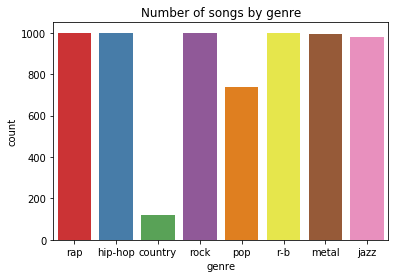

In [16]:
print("Number of songs grouped by genre of music:")
print(data.groupby('genre').count()['lyrics'])
ax = plt.subplots()
ax = sns.countplot(x="genre", data = data, palette= "Set1")
ax.set_title("Number of songs by genre")
plt.show()

**Word clouds by genre**

In [17]:
genres = data.genre.unique()
data_classified = []
for genre in genres:
    lyrics_list = []
    for i in range(len(data.lyrics) ):
        if (data.genre[i]==genre):
            lyrics_list.append(data.lyrics[i])
    data_classified.append(lyrics_list)

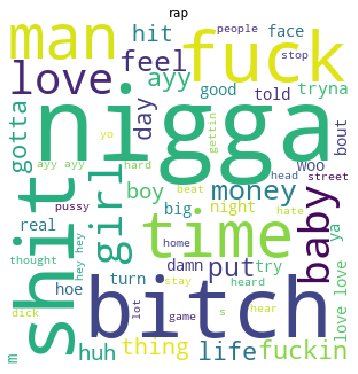

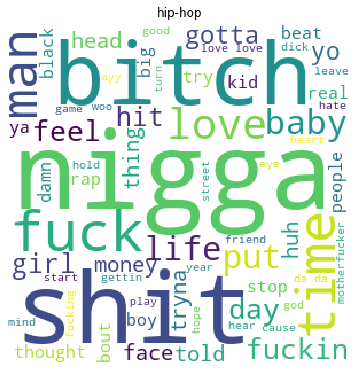

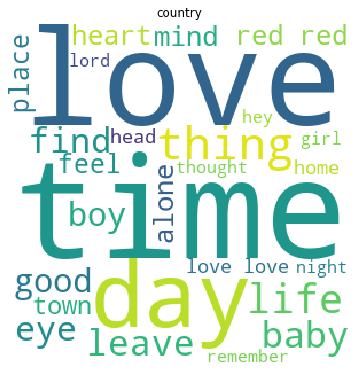

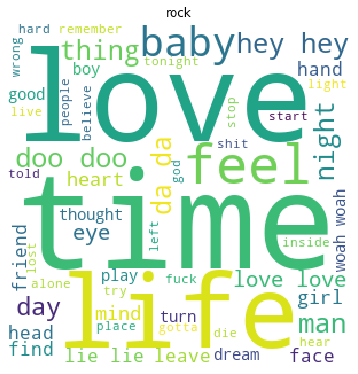

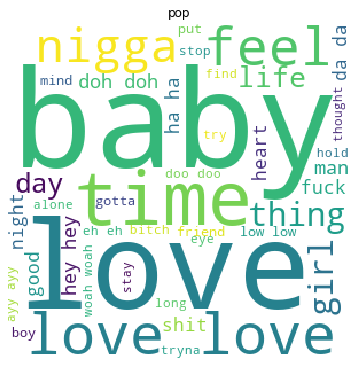

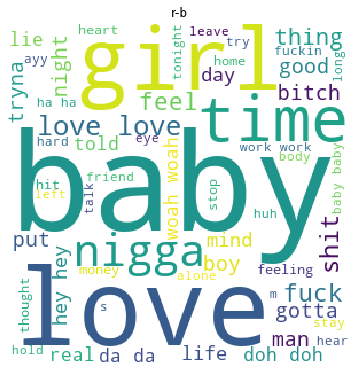

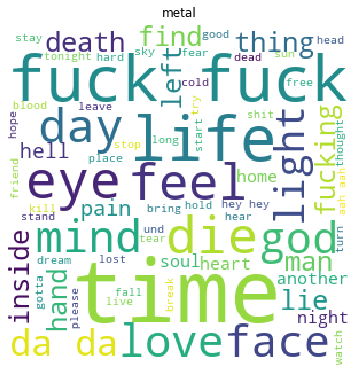

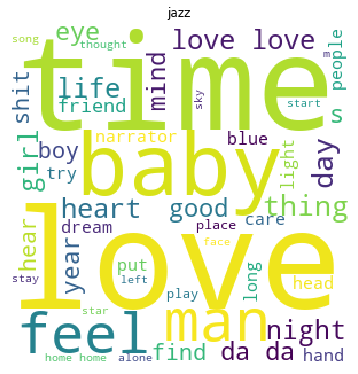

In [18]:
index_genre = 0 
# Iterate through every music genre
for lyrics_of_genre in data_classified :

    wordcloud = WordCloud(width = 300, height = 300,background_color ='white', min_font_size = 10).generate(" ".join(lyrics_of_genre)+" ")

    # plot the WordCloud                       
    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(genres[index_genre])
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    # Save the image in the img folder:
    #wordcloud.to_file("img"+data_genre[index_genre]+"_words.png")
    index_genre +=1

### 2. Data modeling

In [45]:
# Lyrics are the inputs
# Genres are the outputs

# Selecting the columns for training
y = data.genre.values
#x = data.lyrics.values 

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(ngram_range = (1,1),tokenizer = token.tokenize)
x = cv.fit_transform(data['lyrics'])

In [46]:
# Splitting our dataset into train and test parts
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

Bernoulli naive bayes: 0.4359912216532553
Multinomial naive bayes: 0.3833211411850768


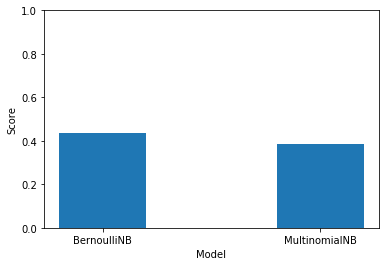

In [47]:
bernoulli_score = BernoulliNB().fit(x_train,y_train).score(x_test,y_test)
print ("Bernoulli naive bayes: %s"%(BernoulliNB().fit(x_train,y_train).score(x_test,y_test)))

multinomial_score = MultinomialNB().fit(x_train,y_train).score(x_test,y_test)
print ("Multinomial naive bayes: %s"%(MultinomialNB().fit(x_train,y_train).score(x_test,y_test)))

x = np.arange(2)
plt.bar(x, height=[bernoulli_score,multinomial_score], width=0.4)
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(x, ['BernoulliNB','MultinomialNB'])
plt.show()

## Comparing with an other dataset

### 1. Cleaning the data

This datasets contains two files, one for the songs and one for the artists. 
This prevent data redundancy and thus reduce the files size as around 300k songs are present.
First, we'll concentrate on the lyrics file to clean it as much a possible and thus reducing its size.
Then, we have to merge the two files in order to have a dataframe containing genre and lyrics.
Finally, we apply the same lyrics cleaning process we used on our own dataset in order to compare them in the same conditions.

In [48]:
# Importing the .csv files

df_lyrics = pd.read_csv("datasets/kaggle-lyrics-data.csv")
df_artists = pd.read_csv("datasets/kaggle-artists-data.csv")

In [49]:
df_lyrics.describe()

,ALink,SName,SLink,Lyric,language
count,379930,379928,379930,379854,365296
unique,4238,267258,379892,371181,52
top,/anjos-anonimos/,Intro,/fishbone/modern-industry.html,Instrumental,en
freq,1029,116,2,2087,191814


In [50]:
# We want to keep only english lyrics, and since all of our songs are in english, we can drop the language column
df_lyrics = df_lyrics[df_lyrics["language"] == "en"]
df_lyrics = df_lyrics.drop(columns=["language"])
df_lyrics.describe()

,ALink,SName,SLink,Lyric
count,191814,191812,191814,191814
unique,2508,138182,191793,189394
top,/frank-sinatra/,Home,/fishbone/modern-industry.html,Shortcut to part of Bill Monroe Lyrics\nBill M...
freq,819,93,2,41


In [51]:
# We get rid of NaN values
df_lyrics.dropna(inplace=True)
df_lyrics.describe()

,ALink,SName,SLink,Lyric
count,191812,191812,191812,191812
unique,2508,138182,191791,189392
top,/frank-sinatra/,Home,/fishbone/modern-industry.html,Shortcut to part of Bill Monroe Lyrics\nBill M...
freq,819,93,2,41


In [52]:
# We get rid of duplicates songs entries
df_lyrics = df_lyrics.drop_duplicates(subset = ["ALink", "SLink"], keep="first")
df_lyrics.describe()

,ALink,SName,SLink,Lyric
count,191791,191791,191791,191791
unique,2508,138162,191791,189392
top,/frank-sinatra/,Home,/dashboard-confessional/nightswimming.html,Shortcut to part of Bill Monroe Lyrics\nBill M...
freq,819,93,1,41


In [53]:
# We still have duplicates on the lyrics. Some of the songs are the same, just sang by another artist
# Lets drop those duplicates too
df_lyrics = df_lyrics.drop_duplicates(subset = ["Lyric"], keep="first")
df_lyrics.describe()

# PS : As we can see, we could've just drop the "Lyric" duplicates as the number of unique lyrics 
# stays the same wether or not we drop the ["ALink", "SLink"] duplicates

,ALink,SName,SLink,Lyric
count,189392,189392,189392,189392
unique,2501,136884,189392,189392
top,/frank-sinatra/,Home,/dashboard-confessional/nightswimming.html,Let me hold you\nFor the last time\nIt's the l...
freq,809,93,1,1


Now we move on to the artists dataframe

In [54]:
df_artists.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [55]:
# First, we drop the useless columns (Artist, Songs, Popularity)
# Second, we remove NaN values

df_artists = df_artists.drop(columns = ['Artist', 'Songs', 'Popularity'])
df_artists.dropna(inplace=True)
df_artists.head()

,Genres,Link
0,Pop; Axé; Romântico,/ivete-sangalo/
1,Axé,/chiclete-com-banana/
2,Axé; Romântico; Reggae,/banda-eva/
3,Axé,/e-o-tchan/
4,Pop; Axé; Romântico,/claudia-leitte/


In [56]:
# The genre column is quite precise
# We only keep the first genre describing each artist
df_artists["Genres"] = df_artists["Genres"].apply(lambda s: s.split(";")[0])
df_artists.head()

,Genres,Link
0,Pop,/ivete-sangalo/
1,Axé,/chiclete-com-banana/
2,Axé,/banda-eva/
3,Axé,/e-o-tchan/
4,Pop,/claudia-leitte/


In [57]:
# Lets consider Heavy Metal as Metal

df_artists[df_artists["Genres"].str.contains("Metal")]["Genres"].value_counts()
df_artists["Genres"] = df_artists["Genres"].replace(to_replace="Heavy Metal", value="Metal")
df_artists[df_artists["Genres"].str.contains("Metal")]["Genres"].value_counts()

Metal    135
Name: Genres, dtype: int64

In [58]:
# Then, we drop every artist that is not doing pop, rock, metal, country, rap, r&b, jazz, hip-hop
genres_list = ["Pop", "Rock", "Rap", "Metal", "Country", "R&B", "Jazz", "Hip Hop"]
df_artists = df_artists[df_artists["Genres"].isin(genres_list)]
df_artists.describe()

,Genres,Link
count,1036,1036
unique,8,1036
top,Rock,/the-notorious-b-i-g/
freq,246,1


In [59]:
# Now we cleaned and reduced our dataframes, we can merge df_artists and df_lyrics
df_artists = df_artists.rename(columns={"Link": "ALink"})
df = pd.merge(df_lyrics, df_artists, on="ALink")

In [60]:
# Lets drop unecessary columns 
df = df.drop(["ALink", "SLink", "SName"], axis=1)
df.describe()

,Lyric,Genres
count,85276,85276
unique,85276,8
top,Let me hold you\nFor the last time\nIt's the l...,Rock
freq,1,24982


In [61]:
# We export this cleaned dataset to avoid making those steps again
df.to_csv("datasets/kaggle-cleaned-and-merge-dataset.csv")

Number of songs grouped by genre of music :


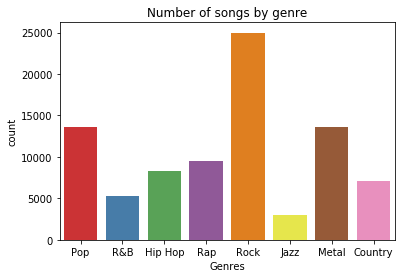

Rock       24982
Pop        13571
Metal      13552
Rap         9465
Hip Hop     8328
Country     7131
R&B         5258
Jazz        2989
Name: Genres, dtype: int64


In [62]:
# Balancing the dataset
print("Number of songs grouped by genre of music :")
ax = plt.subplots()
ax = sns.countplot(x="Genres", data = df, palette= "Set1")
ax.set_title("Number of songs by genre")
plt.show()

print(df["Genres"].value_counts())

Lets keep 2500 of each to make a balanced dataset

In [63]:
random_sample = df.groupby("Genres").apply(lambda x: x.sample(2500)).reset_index(drop=True)
random_sample["Genres"].value_counts()

Country    2500
R&B        2500
Rap        2500
Pop        2500
Rock       2500
Metal      2500
Jazz       2500
Hip Hop    2500
Name: Genres, dtype: int64

In [64]:
# Removing stopwords and special characters

random_sample = random_sample.apply(lambda x: x.str.lower())
random_sample['Lyric'] = random_sample['Lyric'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()\`'|0]|(\n)|(\r)", ' ')
random_sample['Lyric'] = random_sample['Lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [65]:
# Lemmatization of all the lyrics
# We use the same function as for the previous data

df["Lyric"]  = df["Lyric"].apply(lambda x:  lemmatize_lyrics(x))
random_sample.head()

,Lyric,Genres
0,circle people longer ashamed longer fit sober ...,country
1,water tank sleepin rain miles home waitin trai...,country
2,find annie moved town california close close e...,country
3,sweetheart read letter heart hope understand l...,country
4,stay home wait love love baby care lookin love...,country


In [66]:
# After lemmatizing we're checking the most frequent words by genre
for genre in random_sample['Genres'].unique():
    print(genre)
    print(random_sample.loc[random_sample['Genres'] == genre].Lyric.str.split(expand=True).stack().value_counts()[0:10])

country
love     3971
time     1931
baby     1393
heart    1325
home     1089
night    1062
day      1036
long     1001
good      998
life      987
dtype: int64
hip hop
nigga     4724
shit      4154
love      4136
ya        3585
baby      3394
girl      3075
fuck      3002
time      2850
man       2840
niggas    2638
dtype: int64
jazz
love     4350
heart    1397
time     1144
day      1016
night     848
baby      821
life      761
long      572
find      566
eyes      564
dtype: int64
metal
time     1800
life     1765
2        1147
feel     1120
love     1068
night     973
eyes      962
3         916
5         916
day       833
dtype: int64
pop
love       6377
baby       3255
time       2657
feel       1946
girl       1647
heart      1634
good       1477
night      1313
life       1311
tonight    1016
dtype: int64
r&b
love     7664
baby     5467
girl     3258
time     2833
ya       2172
feel     1946
2        1867
man      1746
nigga    1731
good     1603
dtype: int64
rap
nigga     550

**Word clouds**

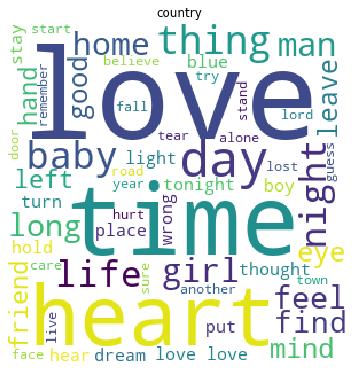

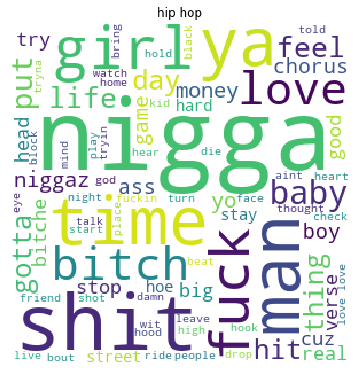

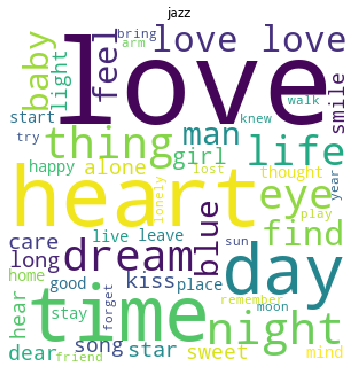

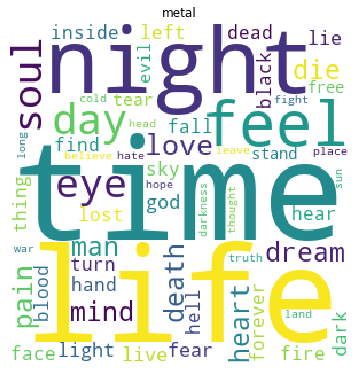

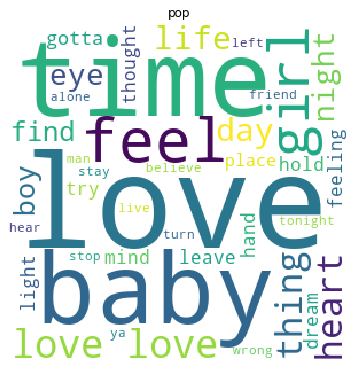

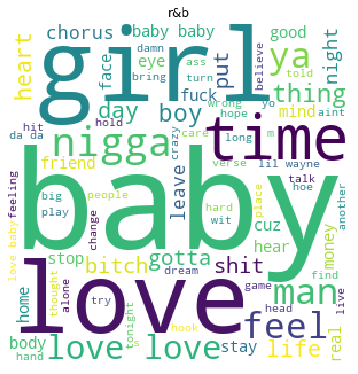

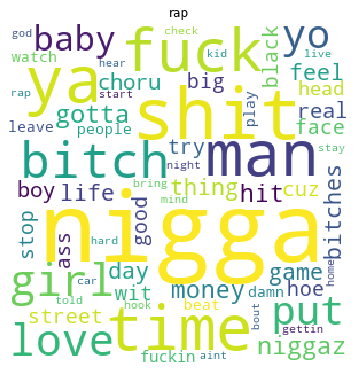

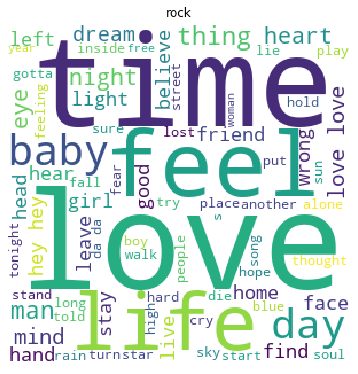

In [67]:
# We apply the same process as for the previous set to buils the word clouds
genres = random_sample.Genres.unique()
data_classified = []
for genre in genres:
    lyrics_list = []
    for i in range(len(random_sample.Lyric)):
        if (random_sample.Genres[i]==genre):
            lyrics_list.append(random_sample.Lyric[i])
    data_classified.append(lyrics_list)

i = 0
for lyrics_of_genre in data_classified :

    wordcloud = WordCloud(width = 300, height = 300,background_color ='white', min_font_size = 10).generate(" ".join(lyrics_of_genre)+" ")

    # plot the WordCloud                       
    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(genres[i])
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    i += 1

### 2. Data modeling

In [68]:
# Selecting the columns for training
y = random_sample.Genres.values

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(ngram_range = (1,1),tokenizer = token.tokenize)
x = cv.fit_transform(random_sample['Lyric'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

kaggle_bernoulli_score = BernoulliNB().fit(x_train,y_train).score(x_test,y_test)
print ("Bernoulli naive bayes: %s"%(BernoulliNB().fit(x_train,y_train).score(x_test,y_test)))

kaggle_multinomial_score = MultinomialNB().fit(x_train,y_train).score(x_test,y_test)
print ("Multinomial naive bayes: %s"%(MultinomialNB().fit(x_train,y_train).score(x_test,y_test)))

Bernoulli naive bayes: 0.51225
Multinomial naive bayes: 0.50825


Having a balanced dataset improve our results, as we have now a score of 50% for both models

## 3. Annex

We want to test if having less categories can inhance the scores. We drop R&B, Jazz and Hip-hop to only keep Pop, Rock, Metal, Rap and Country songs 

In [69]:
random_sample_5_genres = random_sample[random_sample["Genres"].isin(["pop", "rock", "metal", "rap", "country"])]
random_sample_5_genres["Genres"].value_counts()

pop        2500
metal      2500
rap        2500
rock       2500
country    2500
Name: Genres, dtype: int64

In [70]:
# Selecting the columns for training
y = random_sample_5_genres.Genres.values

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(ngram_range = (1,1),tokenizer = token.tokenize)
x = cv.fit_transform(random_sample_5_genres['Lyric'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

kaggle_5_genres_bernoulli_score = BernoulliNB().fit(x_train,y_train).score(x_test,y_test)
print ("Bernoulli naive bayes: %s"%(BernoulliNB().fit(x_train,y_train).score(x_test,y_test)))

kaggle_5_genres_multinomial_score = MultinomialNB().fit(x_train,y_train).score(x_test,y_test)
print ("Multinomial naive bayes: %s"%(MultinomialNB().fit(x_train,y_train).score(x_test,y_test)))

Bernoulli naive bayes: 0.632
Multinomial naive bayes: 0.6136


We obtain better result when restricting ourself to less categories.

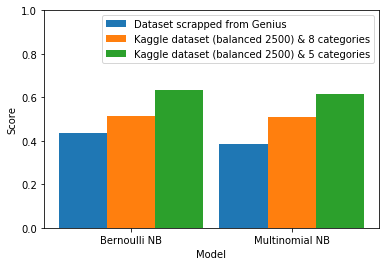

In [72]:
x = np.arange(2)

groups = ['Bernoulli NB', 'Multinomial NB']

our_dataset_scores = [bernoulli_score, multinomial_score]
kaggle_dataset_scores = [kaggle_bernoulli_score, kaggle_multinomial_score]
kaggle_5_genres_dataset_scores = [kaggle_5_genres_bernoulli_score, kaggle_5_genres_multinomial_score]

x_axis = np.arange(len(groups))

plt.bar(x-0.3, our_dataset_scores, width=0.3, label="Dataset scrapped from Genius")
plt.bar(x, kaggle_dataset_scores, width=0.3, label="Kaggle dataset (balanced 2500) & 8 categories")
plt.bar(x+0.3, kaggle_5_genres_dataset_scores, width=0.3, label="Kaggle dataset (balanced 2500) & 5 categories")

plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(x, groups)

plt.legend()
plt.show()